In [1]:
import matplotlib.pyplot as plt
plt.style.use('../../note.mplstyle')
import numpy as np

In [2]:
from qutip import *

# Unit system

Let $R \equiv [\Delta_{0}^{2} + \Delta_{1}^{2} + (J/\hbar)^{2}]^{1/2}$

- The unit of energy : $\hbar R$
- The unit of frequency : $R$

In [3]:
from numpy import pi, cos, sin

In [4]:
N_theta = 25 # 41 # 11 # 3
N_phi = 31 # 51 # 4

theta_max = pi # pi/2.
phi_max = 2*pi

theta_arr = np.linspace(0, theta_max,N_theta)
# N_theta = theta_arr.size
phi_arr = np.linspace(0,phi_max,N_phi)
# N_phi = phi_arr.size

In [5]:
del0_mesh = np.multiply.outer(sin(theta_arr), cos(phi_arr))
del1_mesh = np.multiply.outer(sin(theta_arr), sin(phi_arr))
J_mesh = np.multiply.outer(cos(theta_arr), np.ones_like(phi_arr))

In [6]:
del0_mesh.shape

(25, 31)

In [7]:
# dels_mesh = np.empty()
dels_mesh = np.stack((del0_mesh,del1_mesh))

In [8]:
dels_mesh.shape

(2, 25, 31)

In [9]:
# dels_mesh[(0)]

In [10]:
Omega0_mesh = np.abs(del0_mesh - 2.*J_mesh)

In [11]:
Omega1 = 0.

In [12]:
options = Options(nsteps=20000)

In [13]:
del0_mesh

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.30526192e-01,  1.27673882e-01,  1.19241610e-01,
         1.05597908e-01,  8.73390701e-02,  6.52630961e-02,
         4.03348116e-02,  1.36437023e-02, -1.36437023e-02,
        -4.03348116e-02, -6.52630961e-02, -8.73390701e-02,
        -1.05597908e-01, -1.19241610e-01, -1.27673882e-01,
        -1.30526192e-01, -1.27673882e-01, -1.19241610e-01,
        -1.05597908e-01, -8.73

In [14]:
zero = Qobj(np.zeros((2,2)))

I, sigx, sigy, sigz = identity(2), sigmax(), sigmay(), sigmaz()

sigz_0 = tensor([sigz,I])
sigz_1 = tensor([I,sigz])
sigzlist = [sigz_0, sigz_1]

sigx_0 = tensor([sigx,I])
sigx_1 = tensor([I,sigx])
sigxlist = [sigx_0, sigx_1]

sigzsigz = tensor(sigz,sigz)

In [15]:
N = 2

In [16]:
# params = (f"-{wmw[1]:.4g}-wR0-{wR[0]:.4g}-wR1-{wR[1]:.4g}-J-{J:.4g}-tmax-{tmax}")
# params

In [17]:
params = f"Omega0-resonant-E01-E11_Omega1-zero"
params

'Omega0-resonant-E01-E11_Omega1-zero'

In [18]:
# (1/2**0.5) * tensor([basis(2,1), basis(2,1)]) 
# + (1/2**0.5) * tensor([basis(2,0), basis(2,0)])

In [19]:
ket_11 = tensor([basis(2,0), basis(2,0)])
ket_01 = tensor([basis(2,1), basis(2,0)])

ket_01_plus_11 = (1/2**0.5) * ket_11 + (1/2**0.5) * ket_01

ket_00 = tensor([basis(2,1), basis(2,1)])

ket_00_plus_11 = (1/2**0.5) * ket_00 + (1/2**0.5) * ket_11

rho_00_plus_11 = ket2dm(ket_00_plus_11)

rho_00_plus_11

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]

In [20]:
# ket_01_plus_11.norm()

# ket_00_plus_11.norm()

In [21]:
c_ops = []

In [22]:
tmax = 10 # 100
t = np.linspace(0,tmax,201)

In [23]:
rho_01_plus_11 = ket2dm(ket_01_plus_11)

In [24]:
fidel_00_plus_11 = lambda t, rho: np.real(fidelity(rho_00_plus_11, rho))

In [25]:
# np.arange(24).reshape(2,3,4)

# np.arange(24).reshape(2,3,4)[:,(1,2)]

In [26]:
fidel_00_plus_11_t_mesh = np.empty((N_theta, N_phi, t.size), dtype=np.float64)

print(f"N_theta = {N_theta}, N_phi = {N_phi}")
for indices in np.ndindex((N_theta, N_phi)):
    
    j_theta, j_phi = indices
    print(f"j_theta = {j_theta}")
    dels = dels_mesh[:,j_theta,j_phi]
    J = J_mesh[indices]
    wR = [Omega0_mesh[indices], Omega1]
    
    H0 = tensor([zero,zero])
    for j in range(N):
        H0 += dels[j] * (sigzlist[j]/2.)
    H0 += (- J) * sigzsigz

    Hdrive = tensor([zero,zero])
    for j in range(N):
        Hdrive += wR[j] * (sigxlist[j]/2.)
        
    H = H0 + Hdrive
    
    res = mesolve(H, rho_01_plus_11, t, c_ops, fidel_00_plus_11, options=options)
    fidel_00_plus_11_t_mesh[j_theta,j_phi,:] = res.expect
#     print(indices, res.expect)

In [27]:
fidel_00_plus_11_t_mesh.shape

(25, 31, 201)

In [28]:
fidel_00_plus_11_mesh_max_t = np.max(fidel_00_plus_11_t_mesh, axis=-1)

In [35]:
# fidel_00_plus_11_mesh_max_t

# [TODO] Think about why 

In [44]:
sq_fidel_00_plus_11_t_mesh = np.square(fidel_00_plus_11_t_mesh)

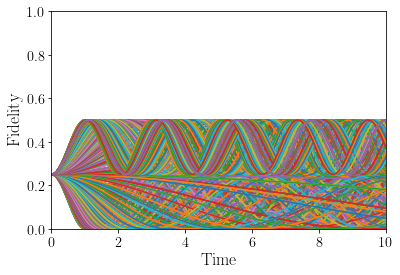

In [46]:
fig, ax = plt.subplots()

for j_theta, j_phi in np.ndindex((N_theta,N_phi)):
    ax.plot(t, sq_fidel_00_plus_11_t_mesh[j_theta,j_phi]) # fidel_00_plus_11_t_mesh
    
ax.set_xlabel("Time")
ax.set_ylabel("Fidelity")
ax.set_ylim(0,1)
ax.set_xlim(t[[0,-1]])
# fig.savefig("fidelity-time-dep-test-005.png")

In [31]:
(1/2.) + (1/2.)*(1/np.sqrt(2))

0.8535533905932737

In [32]:
from ultrashort.plot import color_meshes_from_arrays

phi_over_pi_cmesh, theta_over_pi_cmesh = color_meshes_from_arrays(phi_arr/pi, theta_arr/pi)

In [33]:
N_theta

25

In [48]:
sq_fidel_00_plus_11_mesh_max_t = np.square(fidel_00_plus_11_mesh_max_t)

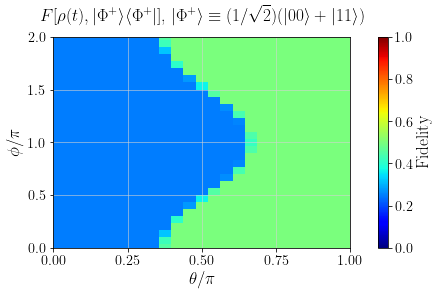

In [54]:
fig, ax = plt.subplots(constrained_layout=True)

cmap = 'jet' # 'binary' # 'bwr'
pcm = ax.pcolormesh(theta_over_pi_cmesh, phi_over_pi_cmesh, 
                    sq_fidel_00_plus_11_mesh_max_t, vmax=1, vmin=0, cmap=cmap) # fidel_00_plus_11_mesh_max_t
ax.set_xlabel(r"$\theta / \pi$")
ax.set_ylabel(r"$\phi / \pi$")
cb = fig.colorbar(pcm, ax=ax)
cb.set_label(r"Fidelity")
ax.set_title(r"$F[\rho(t),|\Phi^{+}\rangle\langle\Phi^{+}|]$"
             r", $|\Phi^{+}\rangle \equiv (1/\sqrt{2})(|00\rangle+|11\rangle)$", pad=15)

ax.xaxis.set_ticks(np.linspace(0,1,5))
ax.grid(True, color='lightgray', alpha=0.75, lw=0.75)

# fig.savefig(f"fidelity-00-plus-11-from-01-plus-11-test-013-{params}.png")